In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import re
import html
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## FILE PATHS

In [15]:
partfilename = "part-r-00000"
metadata_filename = "data/meta_Video_Games.jsonl"
data_filename = "data/Video_Games.jsonl"

## LOAD DATA

In [27]:
data = []

with open(partfilename) as file:
    lines = file.readlines()
    for line in tqdm(lines):
        line = line.strip()
        keys, count = line.split("\t")
        year, month, sentiment, rating, asid = keys.split("-")

        # Add to list as a dictionary
        data.append({
            "year": year,
            "month": month,
            "sentiment": sentiment,
            "rating": rating,
            "asid": asid,
            "count": int(count)
        })

100%|██████████| 2150468/2150468 [00:01<00:00, 1199469.47it/s]


In [28]:
# Create DataFrame from the list of dicts
df = pd.DataFrame(data)
df['year'] = df['year'].astype(int)
# Filter out years before 2010
# df = df[df['year'] >= 2010]
df.head()

,year,month,sentiment,rating,asid,count
0,1999,03,Positive,5,0792837606,1
1,1999,09,Positive,5,B0000061R7,1
2,1999,11,Positive,3,B0000296ZH,1
3,1999,11,Positive,4,B00002EPY1,1
4,1999,11,Positive,5,B0000061R7,1


In [29]:
# Step 1: Load product metadata JSONL
with open(metadata_filename, "r") as f:
    metadata = [json.loads(line) for line in f]

# Step 2: Create mapping: parent_asin → title
title_map = {item["parent_asin"]: item["title"] for item in metadata}

# Step 3: Map titles to review DataFrame based on 'asid'
df["title"] = df["asid"].map(title_map)

# ✅ Optional: See the result
df[["asid", "title"]].head()

# Step 4: Remove rows with missing data
# df = df.dropna()

,asid,title
0,0792837606,NaN
1,B0000061R7,Walk on Water
2,B0000296ZH,Star Trek: Hidden Evil - PC
3,B00002EPY1,Delta Force 2 - PC
4,B0000061R7,Walk on Water


In [30]:
top_products = (
    df.groupby("title")["count"].sum().sort_values(ascending=False).head(5)
)

print(top_products)

title
amFilm Tempered Glass Screen Protector for Nintendo Switch 2017 (2-Pack)                                                                                                    17259
PlayStation Plus: 12 Month Membership [Digital Code]                                                                                                                         8644
PlayStation 4 500GB Console [Old Model][Discontinued]                                                                                                                        5942
Redragon M601 RGB Gaming Mouse Backlit Wired Ergonomic 7 Button Programmable Mouse Centrophorus with Macro Recording & Weight Tuning Set 7200 DPI for Windows PC (Black)     5699
American Sniper: The Autobiography of the Most Lethal Sniper in U.S. Military History                                                                                        5270
Name: count, dtype: int64


### WORD CLOUD

In [31]:
# Load JSONL data
file =  open(data_filename, "r", encoding="utf-8")
lines = file.readlines()

In [ ]:
def get_review_text(lines):
    texts = []
    for line in tqdm(lines):
        try:
            review = json.loads(line)
            # Skip ratings
            if review["rating"] >= 3:
                continue
            raw_text = review["text"]
            clean_text = html.unescape(raw_text)
            clean_text = re.sub(r"<.*?>", " ", clean_text)
            clean_text = re.sub(r"[^a-zA-Z0-9\s']", " ", clean_text).lower()
            tokens = clean_text.split()
            tokens = [word for word in tokens if len(word) > 1 or word in ("i", "a")]
            texts.append(" ".join(tokens))
        except:
            continue  # skip malformed lines

    # Combine all review texts into one string
    all_text = " ".join(texts) 
    return all_text

In [ ]:
def get_title_text(lines):
    texts = []
    for line in tqdm(lines):
        try:
            review = json.loads(line)
            # Skip ratings
            if review["rating"] >= 3:
                continue
            raw_text = review["title"]
            clean_text = html.unescape(raw_text)
            clean_text = re.sub(r"<.*?>", " ", clean_text)
            clean_text = re.sub(r"[^a-zA-Z0-9\s']", " ", clean_text).lower()
            tokens = clean_text.split()
            tokens = [word for word in tokens if len(word) > 1 or word in ("i", "a")]
            texts.append(" ".join(tokens))
        except:
            continue  # skip malformed lines

    # Combine all review texts into one string
    all_text = " ".join(texts) 
    return all_text

In [46]:
def create_wordcloud(all_text, title):
    # Generate the word cloud
    stopwords = set(STOPWORDS)

    # Generate the word cloud
    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        stopwords=stopwords
    ).generate(all_text)

    # Show the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


In [ ]:
all_text = get_review_text(lines)
create_wordcloud(all_text, "Review Text")

100%|██████████| 4624615/4624615 [00:23<00:00, 199081.38it/s]


In [ ]:
all_text = get_title_text(lines)
create_wordcloud(all_text, "Review Text")

### RATING PIE CHART

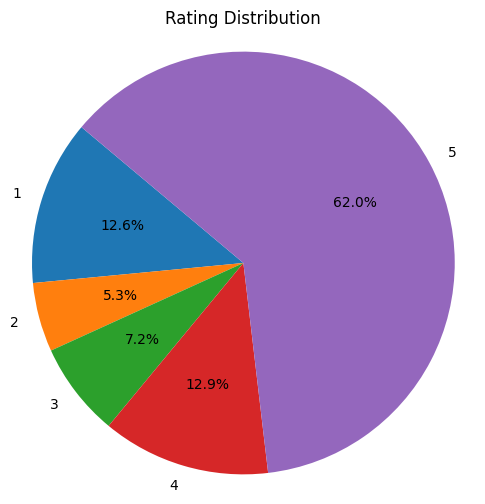

In [33]:
# 🧼 Filter the DataFrame
filtered_df = df

# Aggregate count by sentiment
# sentiment_counts = df.groupby("sentiment")["count"].sum()
sentiment_counts = filtered_df.groupby("rating")["count"].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Rating Distribution")
plt.axis("equal")
plt.show()

### SENTIMENT PIE CHART

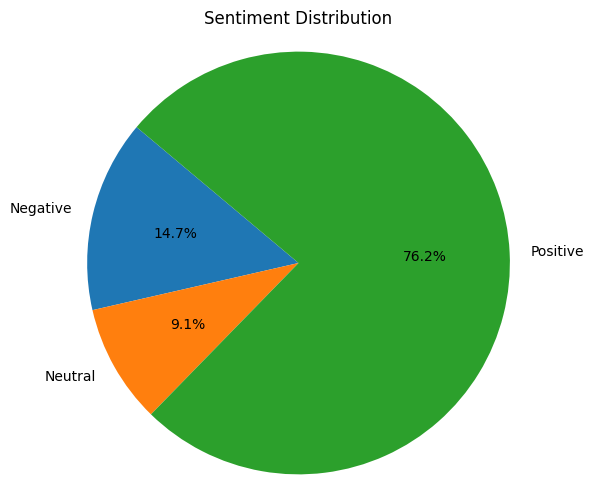

In [34]:
# 🔍 Choose the ASIN (product ID) to filter
target_asid = "B00Y2CQRZY"  # <-- change this to any ASIN you want

# 🧼 Filter the DataFrame
# filtered_df = df[df["asid"] == target_asid]

# Aggregate count by sentiment
# sentiment_counts = df.groupby("sentiment")["count"].sum()
sentiment_counts = df.groupby("sentiment")["count"].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Sentiment Distribution")
plt.axis("equal")
plt.show()

### BAR CHART

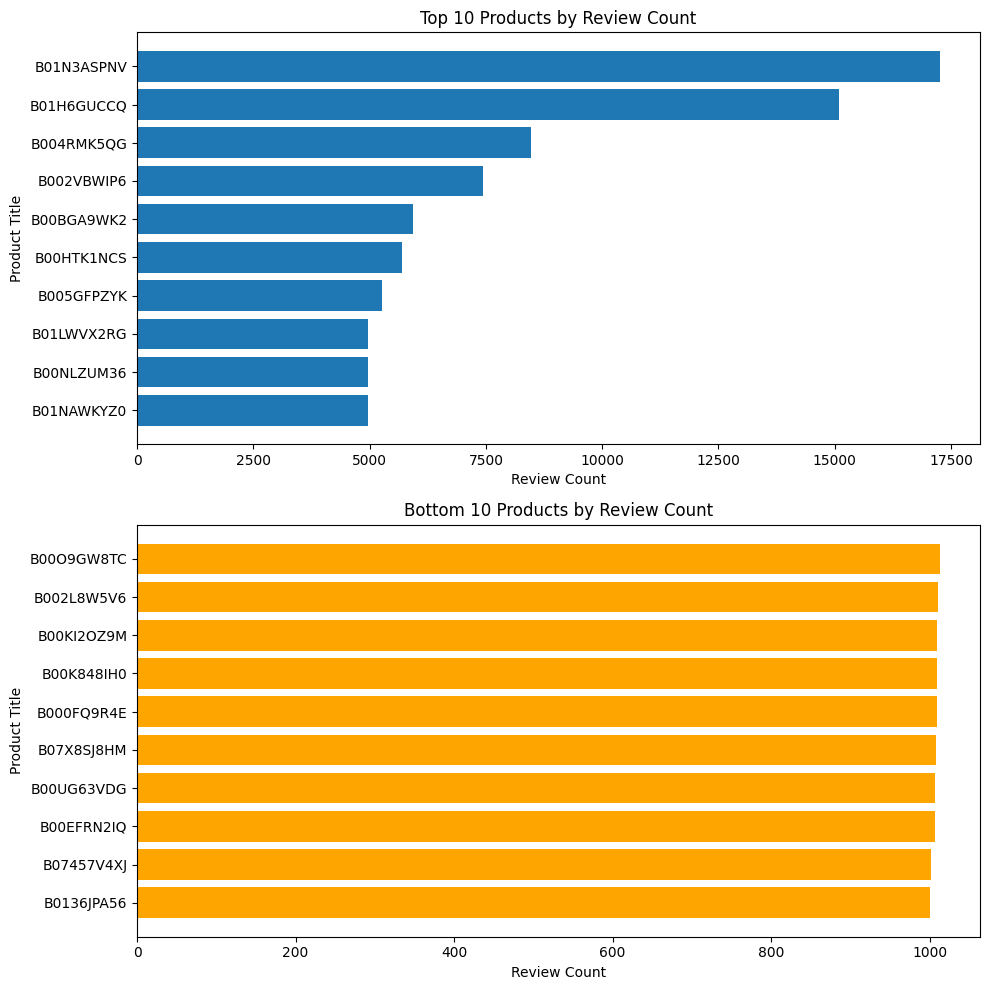

In [35]:
import matplotlib.pyplot as plt

# Group by title and sum review counts
# product_counts = df.groupby("title")["count"].sum()
product_counts = df.groupby("asid")["count"].sum()
# 🔍 Filter out products with fewer than 1000 reviews
filtered_counts = product_counts[product_counts >= 1000]

# Get Top and Bottom 10 products
top_10 = filtered_counts.nlargest(10)
bottom_10 = filtered_counts.nsmallest(10)

# print("🔝 Top 10 Products by Review Count:")
# print(top_10)
# print("\n🔻 Bottom 10 Products by Review Count:")
# print(bottom_10)

# Create subplot with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 🔝 Top 10 - Horizontal Bar Chart
axes[0].barh(top_10.index[::-1], top_10.values[::-1])  # Reverse for highest at top
axes[0].set_title("Top 10 Products by Review Count")
axes[0].set_xlabel("Review Count")
axes[0].set_ylabel("Product Title")

# 🔻 Bottom 10 - Horizontal Bar Chart
axes[1].barh(bottom_10.index, bottom_10.values, color="orange")
axes[1].set_title("Bottom 10 Products by Review Count")
axes[1].set_xlabel("Review Count")
axes[1].set_ylabel("Product Title")

# Layout and show
plt.tight_layout()
plt.show()


### YEARLY SALES

In [12]:
df["year"].max()

2023

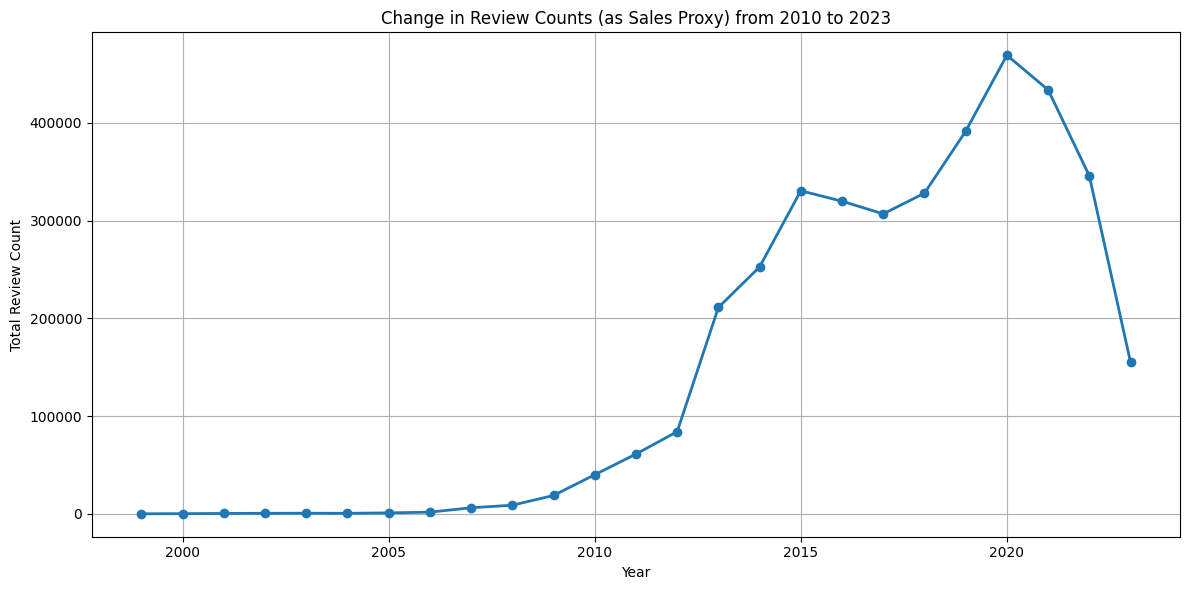

In [36]:
# Group by year and sum the review counts
yearly_sales = df.groupby("year")["count"].sum()

# Sort by year in case it's not already
yearly_sales = yearly_sales.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', linewidth=2)

# Labels and Title
plt.title("Change in Review Counts (as Sales Proxy) from 2010 to 2023")
plt.xlabel("Year")
plt.ylabel("Total Review Count")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


### RATING TRENDS

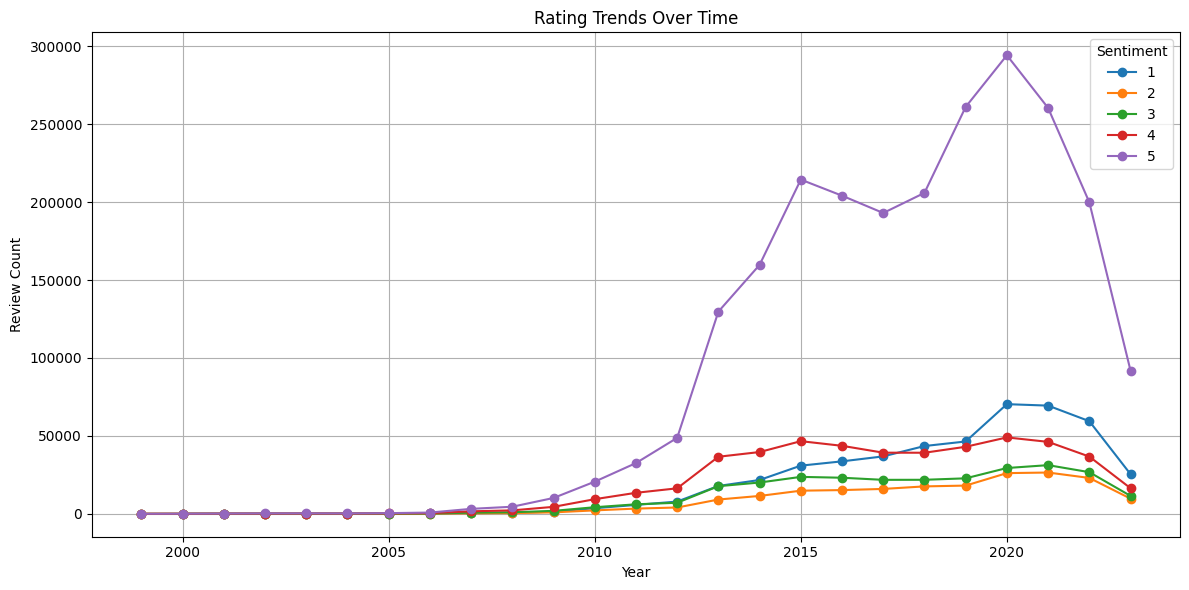

In [37]:
# Group by year and sentiment, then sum the counts
sentiment_trends = df.groupby(["year", "rating"])["count"].sum().unstack()

# Sort by year to ensure proper plotting
sentiment_trends = sentiment_trends.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
for sentiment in sentiment_trends.columns:
    plt.plot(sentiment_trends.index, sentiment_trends[sentiment], marker='o', label=sentiment)

# Labels and Title
plt.title("Rating Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Review Count")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()